# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [5]:
# Load pickled data
import pickle
import numpy as np
from pathlib import Path

# TODO: Fill this in based on where you saved the training and testing data

training_file = "/home/hsharma/Downloads/UND/traffic-signs-data/train.p"
testing_file = "/home/hsharma/Downloads/UND/traffic-signs-data/test.p"


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
class_labels = np.genfromtxt('signnames.csv', dtype=None, delimiter=',', skip_header=1) 
print ("data loaded")

is_data_flip_extended = Path("extended_flip.pickle").is_file()

is_data_transform_extended = Path("extended_dataset3.pickle").is_file()

is_data_preprocessed = Path('final_train.pickle').is_file() and Path('final_valid.pickle').is_file()

is_data_trimmed = Path("trimmed_data.pickle").is_file()

print ("is_data_flip_extended = ", is_data_flip_extended)
print ("is_data_transform_extended = ", is_data_transform_extended)
print ("is_data_preprocessed = ", is_data_preprocessed)
print ("is_data_trimmed = ", is_data_trimmed)


data loaded
is_data_flip_extended =  True
is_data_transform_extended =  True
is_data_preprocessed =  True
is_data_trimmed =  True


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [6]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = str(X_train.shape[1])+"x"+str(X_train.shape[2])+"x"+str(X_train.shape[3])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32x32x3
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [7]:
# Define a function to classify traiing classes based on number of samples to help during augmentation
def count_images(counter):
    augment_level_1 = []
    augment_level_2 = []
    augment_level_3 = []
    augment_level_4 = []
    augment_level_5 = []
    for i in range(len(counter)):
        if counter[i] <= 300:
            augment_level_5.append(i)
        elif counter[i] <= 500:
            augment_level_4.append(i)
        elif counter[i] <= 900:
            augment_level_3.append(i)
        elif counter[i] <= 1500:
            augment_level_2.append(i)
        else:
            augment_level_1.append(i)
            
    return augment_level_1, augment_level_2, augment_level_3, augment_level_4, augment_level_5

Showing image number  9171
class count  [ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


/home/hsharma/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


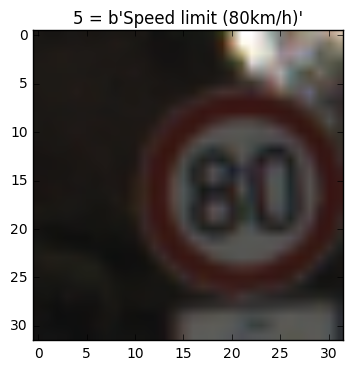

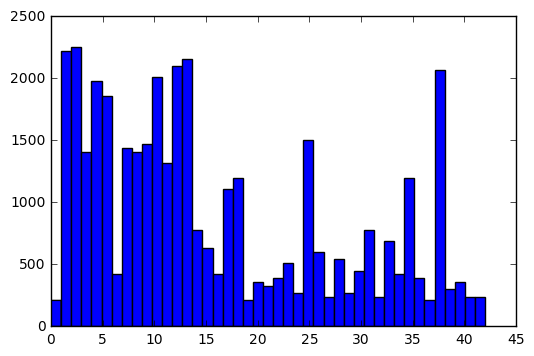

In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from random import randint
# Visualizations will be shown in the notebook.
%matplotlib inline

# Show a random image from dataset along with the label and class
image_num = randint(0,n_train)
print ("Showing image number ", image_num)
plt.figure(1)
plt.title(str(class_labels[y_train[image_num]][0])+" = "+str(class_labels[y_train[image_num]][1]))
plt.imshow(X_train[image_num])

# Count of each class
unique, counter = np.unique(y_train, return_counts=True)
print ("class count ", counter)

# Visualize the unbalance in the classes
f2 = plt.figure(2)
plt.hist(y_train, bins=n_classes)
f2.show()

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
def save_data_pickle(fname, x, y):
#     print('Saving data to pickle file...')
    try:
        with open(fname, 'wb') as pfile:
            pickle.dump(
                {
                    'X_train_extended': x,
                    "y_train_extended": y
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
#         print('Unable to save data to', fname, ':', e)
        raise

#     print('Data cached in pickle file.')

In [10]:
## Generate new data by flipping images
if not is_data_flip_extended:
    flip_y_axis = np.array([11, 18, 22, 26, 30, 35])
    flip_x_axis = np.array([5])
    flip_both = np.array([15, 17])
    flip_origin = np.array([32, 40])

    X_train_extended = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = X_train.dtype)
    y_train_extended = np.empty([0], dtype = y_train.dtype)
    i = 0
    while (i < len(y_train)):
        if y_train[i] in flip_y_axis:
            X_train_extended = np.append(X_train_extended, [X_train[i]], axis=0)
            X_train_extended = np.append(X_train_extended, [X_train[i, :,::-1,:]], axis=0)
            y_train_extended = np.append(y_train_extended, y_train[i])
            y_train_extended = np.append(y_train_extended, y_train[i])
            i+=1
        if y_train[i] in flip_x_axis:
            X_train_extended = np.append(X_train_extended, [X_train[i]], axis=0)
            X_train_extended = np.append(X_train_extended, [X_train[i, ::-1, :, :]], axis=0)
            y_train_extended = np.append(y_train_extended, y_train[i])
            y_train_extended = np.append(y_train_extended, y_train[i])
            i+=1
        if y_train[i] in flip_both:
            X_train_extended = np.append(X_train_extended, [X_train[i]], axis=0)
            X_train_extended = np.append(X_train_extended, [X_train[i, ::-1, :, :]], axis=0)
            X_train_extended = np.append(X_train_extended, [X_train[i, :,::-1,:]], axis=0)
            y_train_extended = np.append(y_train_extended, y_train[i])
            y_train_extended = np.append(y_train_extended, y_train[i])
            y_train_extended = np.append(y_train_extended, y_train[i])
            i+=1
        if y_train[i] in flip_origin:
            X_train_extended = np.append(X_train_extended, [X_train[i]], axis=0)
            X_train_extended = np.append(X_train_extended, [X_train[i, ::-1, ::-1, :]], axis=0)
            y_train_extended = np.append(y_train_extended, y_train[i])
            y_train_extended = np.append(y_train_extended, y_train[i])
            i+=1
        if not (y_train[i] in flip_y_axis or y_train[i] in flip_both or
                y_train[i] in flip_x_axis or y_train[i] in flip_origin):
            X_train_extended = np.append(X_train_extended, X_train[i:i+counter[y_train[i]]], axis=0)
            y_train_extended = np.append(y_train_extended, y_train[i:i+counter[y_train[i]]])
            i+=counter[y_train[i]]
    save_data_pickle('extended_flip.pickle', X_train_extended, y_train_extended)
    is_data_flip_extended = True

### Checkpoint 1 

_Save data_

In [11]:
with open('extended_flip.pickle', mode='rb') as f:
    train = pickle.load(f)

X_train_extended = train['X_train_extended']
y_train_extended = train['y_train_extended']

class count  [ 210 2220 2250 1410 1980 3720  420 1440 1410 1470 2010 2640 2100 2160  780
 1890  420 3330 2400  210  360  330  780  510  270 1500 1200  240  540  270
  900  780  480  689  420 2400  390  210 2070  300  720  240  240]


/home/hsharma/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


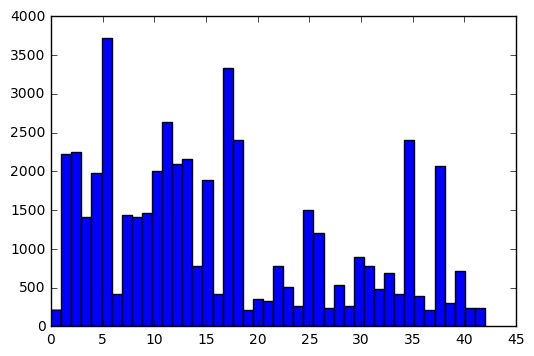

In [12]:
unique, counter = np.unique(y_train_extended, return_counts=True)
augment_level_1, augment_level_2, augment_level_3, augment_level_4, augment_level_5 = count_images(counter)
print ("class count ", counter)
f2 = plt.figure(2)
plt.hist(y_train_extended, bins=n_classes)
f2.show()

In [13]:
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import AffineTransform
from skimage.transform import ProjectiveTransform
from skimage import img_as_ubyte
import random
import sys

if not is_data_transform_extended:
    def augment_image(image, level):
        x_size = 32
        y_size = 32
        img1 = image

        # Rotated
        img_rot_arr =  []
        for i in range(level):
            img_rot_arr.append(img_as_ubyte(rotate(img1,random.uniform(-20,20), mode='edge')))

        # Translated
        img_translated_arr = []
        tform = AffineTransform(translation=[random.uniform(-4,4),random.uniform(-4,4)])
        img_translated_arr.append(img_as_ubyte(warp(img1, tform)))

        for i in range(len(img_rot_arr)):
            tform = AffineTransform(translation=[random.uniform(-4,4),random.uniform(-4,4)])
            img_translated_arr.append(img_as_ubyte(warp(img_rot_arr[i], tform)))

        # Sheared
        tform1 = AffineTransform(shear=random.uniform(-0.2, 0))
        tform2 = AffineTransform(shear=random.uniform(0.01,0.21))
        img_neg_shear_arr = []
        img_pos_shear_arr = []
        img_rev1_shear_arr = []
        img_rev2_shear_arr = []

        img_neg_shear_arr.append(img_as_ubyte(warp(img1, tform1)))
        img_pos_shear_arr.append(img_as_ubyte(warp(img1, tform2)))
        img_rev1_shear_arr.append(img_as_ubyte(warp(img_neg_shear_arr[0], tform2)))
        img_rev2_shear_arr.append(img_as_ubyte(warp(img_pos_shear_arr[0], tform1)))

        for i in range(len(img_rot_arr)):
            tform1 = AffineTransform(shear=random.uniform(-0.2, 0))
            tform2 = AffineTransform(shear=random.uniform(0.01,0.21))
            img_neg_shear_arr.append(img_as_ubyte(warp(img_rot_arr[i], tform1)))
            img_pos_shear_arr.append(img_as_ubyte(warp(img_rot_arr[i], tform2)))
            img_rev1_shear_arr.append(img_as_ubyte(warp(img_neg_shear_arr[i+1], tform2)))
            img_rev2_shear_arr.append(img_as_ubyte(warp(img_pos_shear_arr[i+1], tform1)))


        # Projective transform
        transform = ProjectiveTransform()
        dst = np.array(((0, 0),(0, y_size),(x_size, y_size),(x_size, 0)))
        img_proj_trans_arr = []

        var = random.uniform(-5,5)
        src = (np.array(((var, var),(var, y_size-var),(x_size - var, y_size - var),(x_size - var, var))))
        transform.estimate(src, dst)
        img_proj_trans_arr.append(img_as_ubyte(warp(img1, transform, order = 1, mode = 'edge')))
        for i in range(len(img_rot_arr)):
            var = random.uniform(-5,5)
            src = (np.array(((var, var),(var, y_size-var),(x_size - var, y_size - var),(x_size - var, var))))
            transform.estimate(src, dst)
            img_proj_trans_arr.append(img_as_ubyte(warp(img_rot_arr[i], transform, order = 1, mode = 'edge')))
            img_proj_trans_arr.append(img_as_ubyte(warp(img_translated_arr[i], transform, order = 1, mode = 'edge')))
        if level in [1]:
            final_arr = [img1] + img_rot_arr + img_translated_arr + img_pos_shear_arr
        elif level in [2,3]:
            final_arr = [img1] + img_rot_arr + img_translated_arr + img_pos_shear_arr + img_proj_trans_arr
        else:
            final_arr = [img1] + img_rot_arr + img_translated_arr + img_neg_shear_arr + img_pos_shear_arr + img_rev1_shear_arr + img_rev2_shear_arr + img_proj_trans_arr
        return final_arr

#     X_train_extended2 = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = X_train.dtype)
#     y_train_extended2 = np.empty([0], dtype = y_train.dtype)

    ss = 1000;
    total = X_train_extended.shape[0]
#     i = 0
    while i < total:
        if y_train_extended[i] in augment_level_5:
            images = augment_image(X_train_extended[i], 6)
        elif y_train_extended[i] in augment_level_4:
            images = augment_image(X_train_extended[i], 4)
        elif y_train_extended[i] in augment_level_3:
            images = augment_image(X_train_extended[i], 3)
        elif y_train_extended[i] in augment_level_2:
            images = augment_image(X_train_extended[i], 2)
        elif y_train_extended[i] in augment_level_1:
            images = augment_image(X_train_extended[i], 1)
        X_train_extended2 = np.append(X_train_extended2,images, axis=0)
        y_train_extended2 = np.append(y_train_extended2,[y_train_extended[i]]*len(images))
        if (i%ss == 0):
            sys.stdout.write("i = "+str(i))
        i += 1

    sys.stdout.write(str(X_train_extended2.shape))
    sys.stdout.write(str(y_train_extended2.shape))
    save_data_pickle('extended_dataset3.pickle', X_train_extended2, y_train_extended2)
    is_data_transform_extended = True

### Checkpoint 2 

_Save extended dataset_

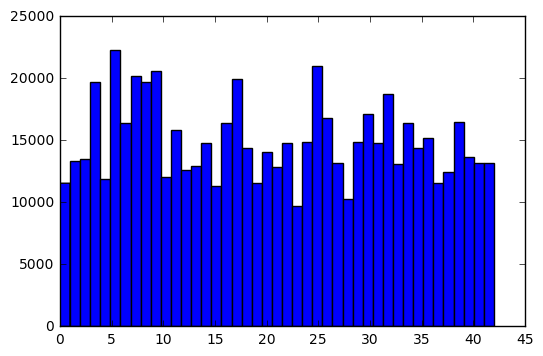

In [14]:
# Visualize final dataset

# save_data_pickle('extended_dataset_t.pickle', X_train_extended2, y_train_extended2)
with open('/home/hsharma/UND/CarND-Traffic-Sign-Classifier-Project/extended_dataset3.pickle', mode='rb') as f:
    train = pickle.load(f)

X_train_final = train['X_train_extended']
y_train_final = train['y_train_extended']
# # print (j)
# X_train_final = X_train_extended2
# y_train_final = y_train_extended2

unique, counter2 = np.unique(y_train_final, return_counts=True)

plt.figure(2)
plt.hist(y_train_final, bins=n_classes)
plt.show()

In [15]:
if not is_data_trimmed:
    i = 0
    X_trimmed = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = X_train.dtype)
    y_trimmed = np.empty([0], dtype = y_train.dtype)
    start = 0
    while (i<n_classes):
        print (i)
        end = start+min(8000, counter2[i])
        X_trimmed = np.append(X_trimmed, X_train_final[start:end], axis=0)
        y_trimmed = np.append(y_trimmed, y_train_final[start:end])
        start += counter2[i]
        i += 1
    print (X_trimmed.shape)
    print (y_trimmed.shape)
    save_data_pickle('trimmed_data.pickle', X_trimmed, y_trimmed)

is_data_trimmed = False

In [16]:
if is_data_trimmed:
    with open('trimmed_data.pickle', mode='rb') as f:
        train = pickle.load(f)

    X_trimmed = train['X_train_extended']
    y_trimmed = train['y_train_extended']

In [17]:
if not is_data_trimmed:
    X_trimmed = X_train_final
    y_trimmed = y_train_final

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
import tensorflow
from skimage import color

if not is_data_preprocessed:
    # Apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(y_trimmed)
    y_train_final = encoder.transform(y_trimmed)
    y_test = encoder.transform(y_test)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train_final = y_train_final.astype(np.float32)
    y_test = y_test.astype(np.float32)

    # Convert to grayscale
    X_train_gray = np.empty([0, 32,32], dtype=X_train_final.dtype)
    chunk_size = 100000
    for i in range(0, X_train_final.shape[0], chunk_size):
        start = i
#         fname = "exg"+str(i)+".pickle"
        print (start)
        end = min(i+chunk_size, X_train_final.shape[0])
        X_train_gray = np.append(X_train_gray, np.dot(X_trimmed[start:end][...,:3],[0.299,0.587,0.114]), axis=0)
#         save_data_pickle(f_name, X_train_gray, y_train_final[start:end])
        
    
    X_test_gray = np.dot(X_test[...][...,:3],[0.299,0.587,0.114])

    # Normalize
    X_train_g = (X_train_gray - np.mean(X_train_gray))/np.std(X_train_gray)
    X_test_g =(X_test_gray - np.mean(X_test_gray))/np.std(X_test_gray)

    # Split into training and validation
    train_features, valid_features, train_labels, valid_labels = train_test_split(
        X_train_g,
        y_train_final,
        test_size=0.20,
        random_state=8998)

    # Final save
    save_data_pickle('final_train.pickle', train_features, train_labels)
    save_data_pickle('final_valid.pickle', valid_features, valid_labels)
    save_data_pickle('final_test.pickle', X_test_g, y_test)
    


### Checkpoint 3

_Finished preprocessing_

In [19]:
train_features, valid_features, train_labels, valid_labels = train_test_split(
        X_trimmed,
        y_trimmed,
        test_size=0.23,
        random_state=8998)

# Shuffle
train_features, train_labels = shuffle(train_features, train_labels)
valid_features, valid_labels = shuffle(valid_features, valid_labels)


Class 0: (0, b'Speed limit (20km/h)')  11550 samples


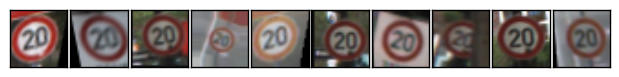

--------------------------------------------------------------------------------------

Class 1: (1, b'Speed limit (30km/h)')  13320 samples


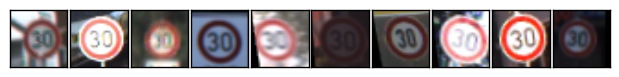

--------------------------------------------------------------------------------------

Class 2: (2, b'Speed limit (50km/h)')  13500 samples


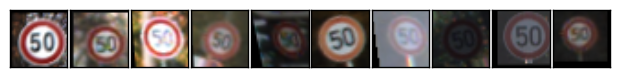

--------------------------------------------------------------------------------------

Class 3: (3, b'Speed limit (60km/h)')  19740 samples


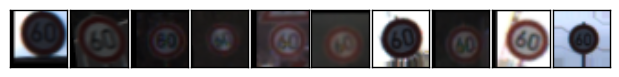

--------------------------------------------------------------------------------------

Class 4: (4, b'Speed limit (70km/h)')  11880 samples


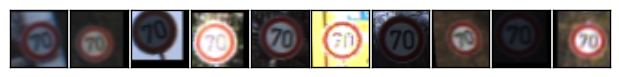

--------------------------------------------------------------------------------------

Class 5: (5, b'Speed limit (80km/h)')  22320 samples


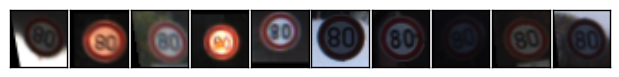

--------------------------------------------------------------------------------------

Class 6: (6, b'End of speed limit (80km/h)')  16380 samples


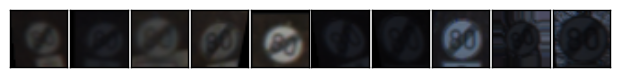

--------------------------------------------------------------------------------------

Class 7: (7, b'Speed limit (100km/h)')  20160 samples


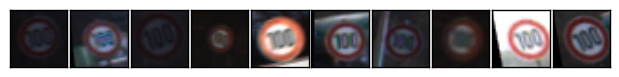

--------------------------------------------------------------------------------------

Class 8: (8, b'Speed limit (120km/h)')  19740 samples


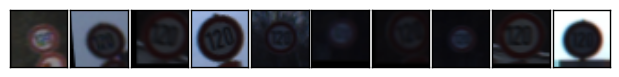

--------------------------------------------------------------------------------------

Class 9: (9, b'No passing')  20580 samples


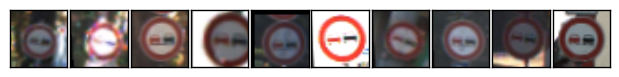

--------------------------------------------------------------------------------------

Class 10: (10, b'No passing for vehicles over 3.5 metric tons')  12060 samples


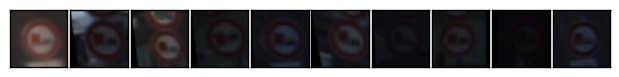

--------------------------------------------------------------------------------------

Class 11: (11, b'Right-of-way at the next intersection')  15840 samples


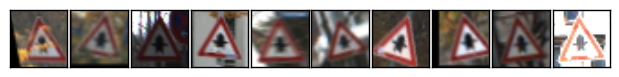

--------------------------------------------------------------------------------------

Class 12: (12, b'Priority road')  12600 samples


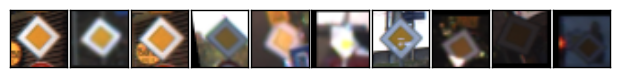

--------------------------------------------------------------------------------------

Class 13: (13, b'Yield')  12960 samples


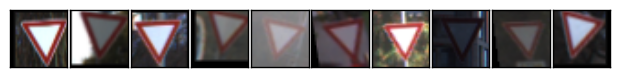

--------------------------------------------------------------------------------------

Class 14: (14, b'Stop')  14820 samples


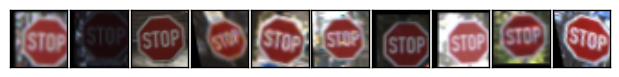

--------------------------------------------------------------------------------------

Class 15: (15, b'No vehicles')  11340 samples


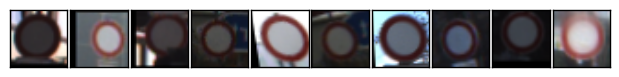

--------------------------------------------------------------------------------------

Class 16: (16, b'Vehicles over 3.5 metric tons prohibited')  16380 samples


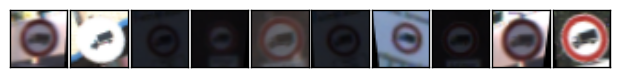

--------------------------------------------------------------------------------------

Class 17: (17, b'No entry')  19980 samples


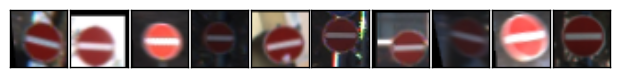

--------------------------------------------------------------------------------------

Class 18: (18, b'General caution')  14400 samples


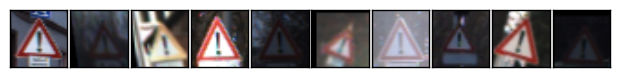

--------------------------------------------------------------------------------------

Class 19: (19, b'Dangerous curve to the left')  11550 samples


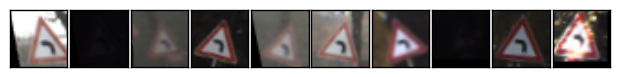

--------------------------------------------------------------------------------------

Class 20: (20, b'Dangerous curve to the right')  14040 samples


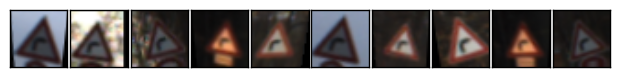

--------------------------------------------------------------------------------------

Class 21: (21, b'Double curve')  12870 samples


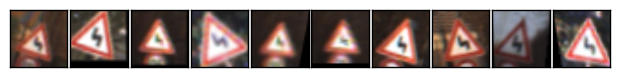

--------------------------------------------------------------------------------------

Class 22: (22, b'Bumpy road')  14820 samples


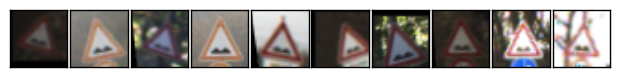

--------------------------------------------------------------------------------------

Class 23: (23, b'Slippery road')  9690 samples


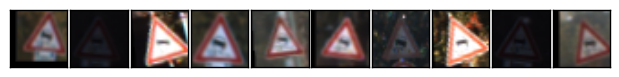

--------------------------------------------------------------------------------------

Class 24: (24, b'Road narrows on the right')  14850 samples


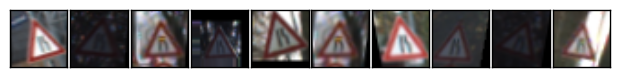

--------------------------------------------------------------------------------------

Class 25: (25, b'Road work')  21000 samples


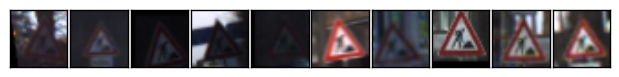

--------------------------------------------------------------------------------------

Class 26: (26, b'Traffic signals')  16800 samples


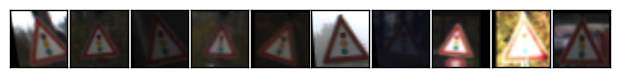

--------------------------------------------------------------------------------------

Class 27: (27, b'Pedestrians')  13200 samples


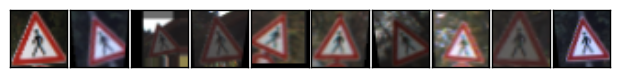

--------------------------------------------------------------------------------------

Class 28: (28, b'Children crossing')  10260 samples


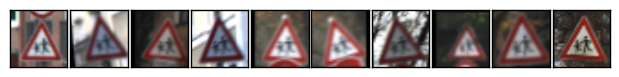

--------------------------------------------------------------------------------------

Class 29: (29, b'Bicycles crossing')  14850 samples


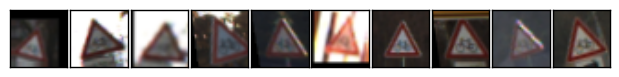

--------------------------------------------------------------------------------------

Class 30: (30, b'Beware of ice/snow')  17100 samples


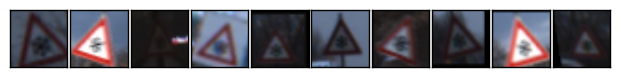

--------------------------------------------------------------------------------------

Class 31: (31, b'Wild animals crossing')  14820 samples


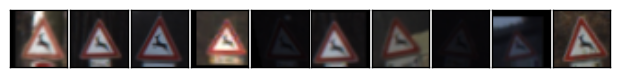

--------------------------------------------------------------------------------------

Class 32: (32, b'End of all speed and passing limits')  18720 samples


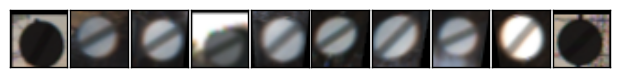

--------------------------------------------------------------------------------------

Class 33: (33, b'Turn right ahead')  13091 samples


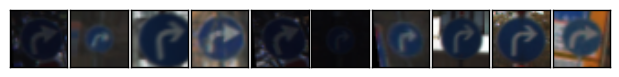

--------------------------------------------------------------------------------------

Class 34: (34, b'Turn left ahead')  16380 samples


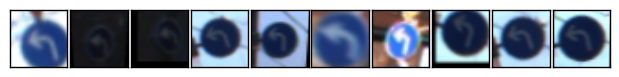

--------------------------------------------------------------------------------------

Class 35: (35, b'Ahead only')  14400 samples


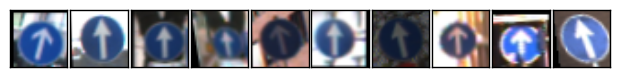

--------------------------------------------------------------------------------------

Class 36: (36, b'Go straight or right')  15210 samples


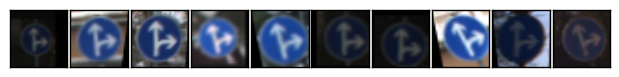

--------------------------------------------------------------------------------------

Class 37: (37, b'Go straight or left')  11550 samples


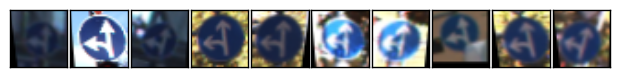

--------------------------------------------------------------------------------------

Class 38: (38, b'Keep right')  12420 samples


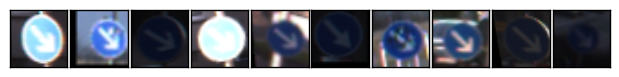

--------------------------------------------------------------------------------------

Class 39: (39, b'Keep left')  16500 samples


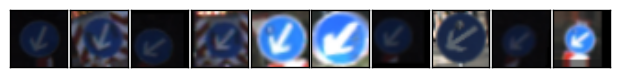

--------------------------------------------------------------------------------------

Class 40: (40, b'Roundabout mandatory')  13680 samples


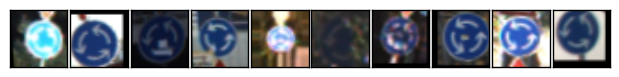

--------------------------------------------------------------------------------------

Class 41: (41, b'End of no passing')  13200 samples


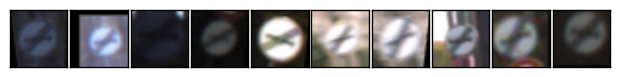

--------------------------------------------------------------------------------------

Class 42: (42, b'End of no passing by vehicles over 3.5 metric tons')  13200 samples


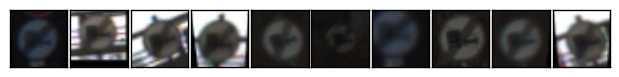

--------------------------------------------------------------------------------------



In [20]:
import random

col_width = max(len(label) for label in class_labels)
sign_classes, class_indices, class_counts = np.unique(y_trimmed, return_index = True, return_counts = True)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, col_width, class_labels[c], str(c_count)))
    fig = plt.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_trimmed[random_indices[i]])
    plt.show()
    print("--------------------------------------------------------------------------------------\n")
    

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**


On visualizing the number of images in each classes, I realized the data was quite skewed. So, in order to make the dataset uniform, I used data augmentation

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

For data augmentation I followed the following steps

1) Identified classes that can be flipped either along the horizontal axis or the vertical axis or the origin. I considered only the classes which do not change on flipping. There were some classes for which the label needed to be updated after flipping, so I ignored these.

2) Created new np arrays containing the original and flipped images and the respective classes

3) Since, even after flip the data was still not uniform, I added more images using the augment_image function which  adds the images with following transforms
- Roatated between angle -20 to 20
- Translated between -3 to 3 on both the axis
- Sheared with a factor between -0.2 to 0
- Sheared with a factor between 0.01 to 0.2
- Sheared c,d with factor of opposite sign as earlier
- Projective transformed

4) To make all the data uniform and remove help improve accuracy, I augmented all classes so that there are no issues because of the black border added due to translation and shearing

5) Once the data was augmented and saved, I used 20% of it for validation and remaining for training

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [21]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [22]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [23]:
def LeNet(x):    
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [24]:
def LeNetModified(x):    
    mu = 0
    sigma = 0.11
    dropout = 0.75
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x8.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 8), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(8))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 30x30x8. Output = 15x15x8.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    

    #----------------------------------------------------------------------------------

    # SOLUTION: Layer 2: Convolutional. Inout = 15x15x8. Output = 12x12x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 8, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
#     conv2 = tf.nn.tanh(conv2)
    # SOLUTION: Pooling. Input = 12x12x32. Output = 6x6x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #----------------------------------------------------------------------------------

    # SOLUTION: Flatten. Input = 6x6x32. Output = 1152.
    fc0   = flatten(conv2)
    
    #----------------------------------------------------------------------------------
    
    # SOLUTION: Layer 4: Fully Connected. Input = 600. Output = 450.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1152, 576), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(576))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    #----------------------------------------------------------------------------------

    # SOLUTION: Layer 5: Fully Connected. Input = 450. Output = 300.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(576, 192), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(192))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    #----------------------------------------------------------------------------------

    # SOLUTION: Layer 5: Fully Connected. Input = 300. Output = 150.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(192, 96), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(96))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # SOLUTION: Activation.
    fc3    = tf.nn.relu(fc3)
    
    #----------------------------------------------------------------------------------

    # SOLUTION: Layer 5: Fully Connected. Input = 150. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(96, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
After playing around with the number of layers, the activation functions, dropout and max pooling size, the final architecture follows a LeNet model


#### Layer 1: Convolutional. 

- Input = 32x32x3. Output = 28x28x6.

- Activation - relu

- max_pooling (k = 2) Output - 14x14x6


#### Layer 2: Convolutional. 

- Input = 14x14x6. Output = 10x10x16.

- Activation - relu

- max_pooling (k = 2) Output - 5x5x16


#### Flatten. 

- Input = 5x5x16. Output = 400.
    
    
#### Layer 3: Fully Connected.

- Input = 400. Output = 120.
    
- Activation - relu


#### Layer 4: Fully Connected. 

- Input = 120. Output = 84.
    
- Activation - relu
    
#### Layer 5: Fully Connected.

- Input = 84. Output = 43.


In [25]:
from tqdm import tqdm

EPOCHS = 15
BATCH_SIZE = 256
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32,3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)


logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [26]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [23]:
EPOCHS = 50
BATCH_SIZE = 420
import time
val_acc = [];
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_final)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        print (i+1, " of ", EPOCHS)
        train_features, train_labels = shuffle(X_train_final, y_train_final)
        
        for offset in tqdm(range(0, num_examples, BATCH_SIZE)):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_features[offset:end], train_labels[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
#         train_accuracy = evaluate(train_features, train_labels)
        validation_accuracy = evaluate(valid_features, valid_labels)
        print("EPOCH {} ...".format(i+1))
#         print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        val_acc.append(validation_accuracy)
        print()
        
    saver.save(sess, './models/lenet__2')
    print("Model saved")
    print ("Time taken = ", (time.time()-start_time)/60, " minutes")

Training...

1  of  50


100%|██████████| 1533/1533 [05:41<00:00,  4.93it/s]


EPOCH 1 ...
Validation Accuracy = 0.848

2  of  50


100%|██████████| 1533/1533 [05:12<00:00,  5.19it/s]


EPOCH 2 ...
Validation Accuracy = 0.910

3  of  50


100%|██████████| 1533/1533 [05:32<00:00,  5.23it/s]


EPOCH 3 ...
Validation Accuracy = 0.931

4  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.32it/s]


EPOCH 4 ...
Validation Accuracy = 0.950

5  of  50


100%|██████████| 1533/1533 [05:27<00:00,  5.28it/s]


EPOCH 5 ...
Validation Accuracy = 0.961

6  of  50


100%|██████████| 1533/1533 [05:18<00:00,  5.29it/s]


EPOCH 6 ...
Validation Accuracy = 0.962

7  of  50


100%|██████████| 1533/1533 [05:12<00:00,  5.34it/s]


EPOCH 7 ...
Validation Accuracy = 0.968

8  of  50


100%|██████████| 1533/1533 [05:11<00:00,  5.35it/s]


EPOCH 8 ...
Validation Accuracy = 0.971

9  of  50


100%|██████████| 1533/1533 [05:36<00:00,  5.26it/s]


EPOCH 9 ...
Validation Accuracy = 0.975

10  of  50


100%|██████████| 1533/1533 [05:38<00:00,  5.34it/s]


EPOCH 10 ...
Validation Accuracy = 0.977

11  of  50


100%|██████████| 1533/1533 [05:27<00:00,  5.24it/s]


EPOCH 11 ...
Validation Accuracy = 0.975

12  of  50


100%|██████████| 1533/1533 [05:19<00:00,  5.36it/s]


EPOCH 12 ...
Validation Accuracy = 0.976

13  of  50


100%|██████████| 1533/1533 [05:19<00:00,  5.38it/s]


EPOCH 13 ...
Validation Accuracy = 0.980

14  of  50


100%|██████████| 1533/1533 [05:17<00:00,  5.25it/s]


EPOCH 14 ...
Validation Accuracy = 0.981

15  of  50


100%|██████████| 1533/1533 [05:13<00:00,  5.30it/s]


EPOCH 15 ...
Validation Accuracy = 0.980

16  of  50


100%|██████████| 1533/1533 [05:14<00:00,  5.32it/s]


EPOCH 16 ...
Validation Accuracy = 0.983

17  of  50


100%|██████████| 1533/1533 [05:12<00:00,  5.21it/s]


EPOCH 17 ...
Validation Accuracy = 0.981

18  of  50


100%|██████████| 1533/1533 [05:11<00:00,  5.25it/s]


EPOCH 18 ...
Validation Accuracy = 0.983

19  of  50


100%|██████████| 1533/1533 [05:15<00:00,  5.36it/s]


EPOCH 19 ...
Validation Accuracy = 0.974

20  of  50


100%|██████████| 1533/1533 [05:18<00:00,  5.37it/s]


EPOCH 20 ...
Validation Accuracy = 0.984

21  of  50


100%|██████████| 1533/1533 [05:13<00:00,  5.24it/s]


EPOCH 21 ...
Validation Accuracy = 0.985

22  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.21it/s]


EPOCH 22 ...
Validation Accuracy = 0.985

23  of  50


100%|██████████| 1533/1533 [05:13<00:00,  5.34it/s]


EPOCH 23 ...
Validation Accuracy = 0.979

24  of  50


100%|██████████| 1533/1533 [05:14<00:00,  5.38it/s]


EPOCH 24 ...
Validation Accuracy = 0.985

25  of  50


100%|██████████| 1533/1533 [05:14<00:00,  5.22it/s]


EPOCH 25 ...
Validation Accuracy = 0.978

26  of  50


100%|██████████| 1533/1533 [05:15<00:00,  5.29it/s]


EPOCH 26 ...
Validation Accuracy = 0.984

27  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.25it/s]


EPOCH 27 ...
Validation Accuracy = 0.986

28  of  50


100%|██████████| 1533/1533 [05:15<00:00,  5.31it/s]


EPOCH 28 ...
Validation Accuracy = 0.985

29  of  50


100%|██████████| 1533/1533 [05:15<00:00,  5.23it/s]


EPOCH 29 ...
Validation Accuracy = 0.987

30  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.30it/s]


EPOCH 30 ...
Validation Accuracy = 0.988

31  of  50


100%|██████████| 1533/1533 [05:17<00:00,  5.14it/s]


EPOCH 31 ...
Validation Accuracy = 0.986

32  of  50


100%|██████████| 1533/1533 [05:17<00:00,  5.28it/s]


EPOCH 32 ...
Validation Accuracy = 0.986

33  of  50


100%|██████████| 1533/1533 [05:15<00:00,  5.27it/s]


EPOCH 33 ...
Validation Accuracy = 0.984

34  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.16it/s]


EPOCH 34 ...
Validation Accuracy = 0.987

35  of  50


100%|██████████| 1533/1533 [05:15<00:00,  5.28it/s]


EPOCH 35 ...
Validation Accuracy = 0.987

36  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.29it/s]


EPOCH 36 ...
Validation Accuracy = 0.987

37  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.28it/s]


EPOCH 37 ...
Validation Accuracy = 0.987

38  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.27it/s]


EPOCH 38 ...
Validation Accuracy = 0.985

39  of  50


100%|██████████| 1533/1533 [05:18<00:00,  4.67it/s]


EPOCH 39 ...
Validation Accuracy = 0.989

40  of  50


100%|██████████| 1533/1533 [05:17<00:00,  5.22it/s]


EPOCH 40 ...
Validation Accuracy = 0.987

41  of  50


100%|██████████| 1533/1533 [05:16<00:00,  5.24it/s]


EPOCH 41 ...
Validation Accuracy = 0.987

42  of  50


100%|██████████| 1533/1533 [05:18<00:00,  5.29it/s]


EPOCH 42 ...
Validation Accuracy = 0.985

43  of  50


100%|██████████| 1533/1533 [05:19<00:00,  5.25it/s]


EPOCH 43 ...
Validation Accuracy = 0.987

44  of  50


100%|██████████| 1533/1533 [05:21<00:00,  5.28it/s]


EPOCH 44 ...
Validation Accuracy = 0.989

45  of  50


100%|██████████| 1533/1533 [05:23<00:00,  5.24it/s]


EPOCH 45 ...
Validation Accuracy = 0.988

46  of  50


100%|██████████| 1533/1533 [05:18<00:00,  5.19it/s]


EPOCH 46 ...
Validation Accuracy = 0.986

47  of  50


100%|██████████| 1533/1533 [05:21<00:00,  4.93it/s]


EPOCH 47 ...
Validation Accuracy = 0.988

48  of  50


100%|██████████| 1533/1533 [05:21<00:00,  5.24it/s]


EPOCH 48 ...
Validation Accuracy = 0.987

49  of  50


100%|██████████| 1533/1533 [05:19<00:00,  5.19it/s]


EPOCH 49 ...
Validation Accuracy = 0.987

50  of  50


100%|██████████| 1533/1533 [05:20<00:00,  4.79it/s]


EPOCH 50 ...
Validation Accuracy = 0.985

Model saved
Time taken =  366.53019318977994  minutes


In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.944


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

- Training:Validation - 80:20

- Optimizer - AdamOptimizer

- Batch Size - 400

- Epochs - 35

- Learning Rate - 0.001

- Softmax on logits

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

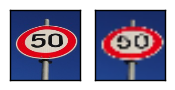

----------------------------------------------



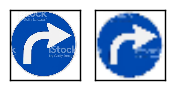

----------------------------------------------



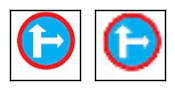

----------------------------------------------



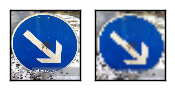

----------------------------------------------



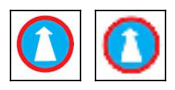

----------------------------------------------



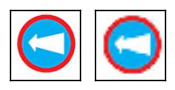

----------------------------------------------



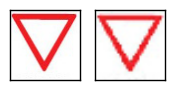

----------------------------------------------



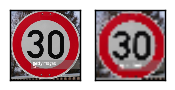

----------------------------------------------



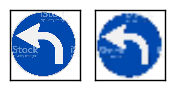

----------------------------------------------



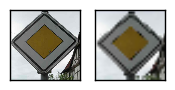

----------------------------------------------

(10, 32, 32, 3)


In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# img.thumbnail((64, 64), Image.ANTIALIAS) # resizes image in-place
# imgplot = plt.imshow(img)

folder_name = "new_images/"
img_arr = []
for fname in os.listdir(folder_name):
    img = Image.open(folder_name + fname)
    img_resized = img.resize((32,32))
    img_resized = np.asarray(img_resized)
    img_arr.append(img_resized)
    
    fig = plt.figure(figsize = (2, 1))
    
    # Show original image
    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(img)
    
    # Show resized image
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(img_resized)
    
    plt.show()
    print("----------------------------------------------\n")
    
new_images = np.array(img_arr)
print (new_images.shape)

In [87]:
import tensorflow as tf
saver = tf.train.Saver()

new_images_labels_actual = np.array([2, 33, 36, 38, 35, 39, 13, 1, 34, 12])

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_images_labels_predicted = sess.run(logits, feed_dict={x: new_images})
    
    test_accuracy = evaluate(new_images, new_images_labels_actual)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Test Accuracy = 0.700


--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------


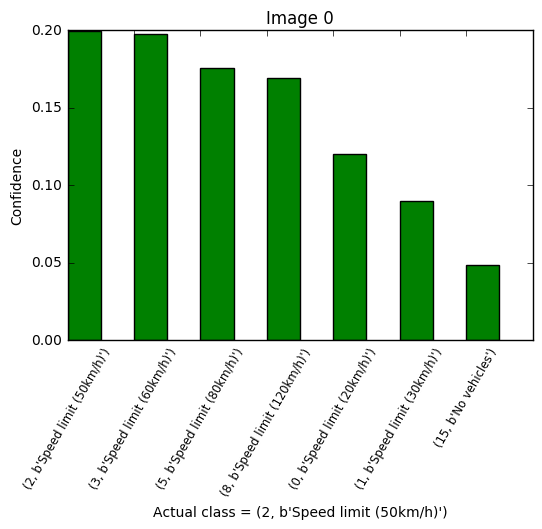

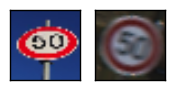

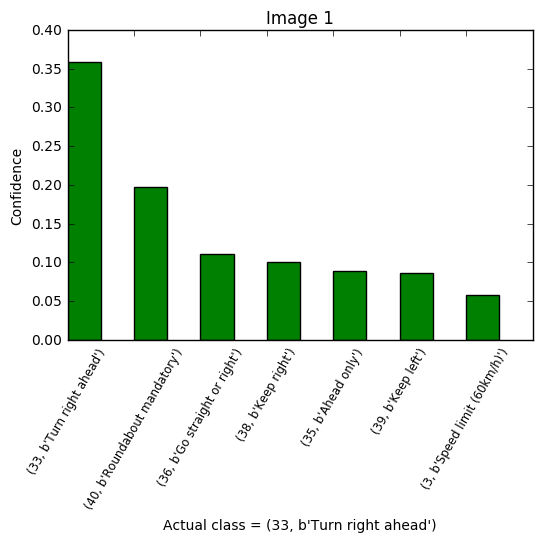

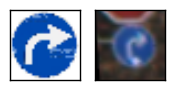

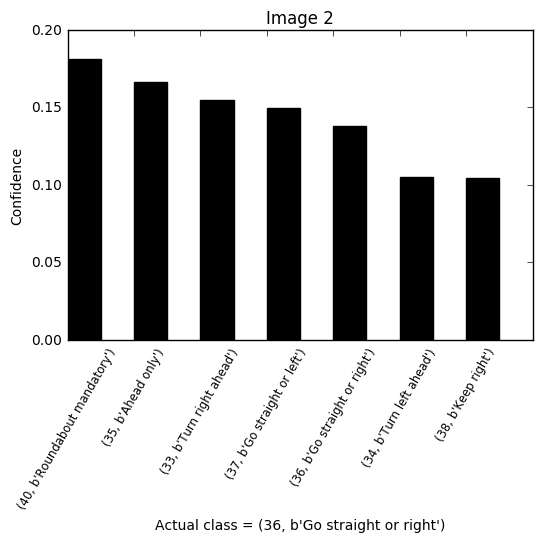

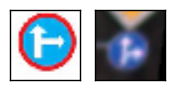

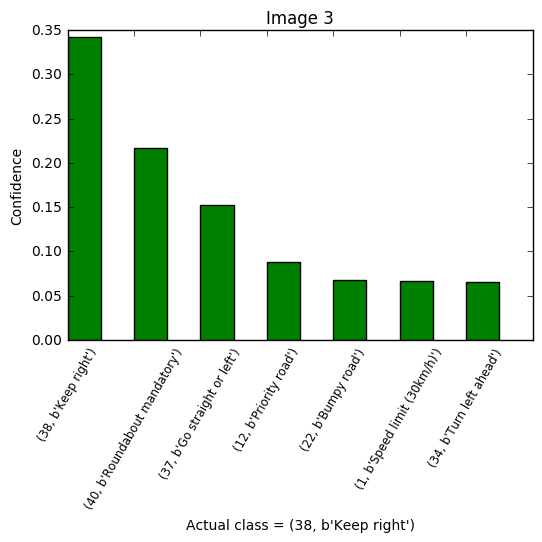

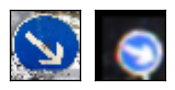

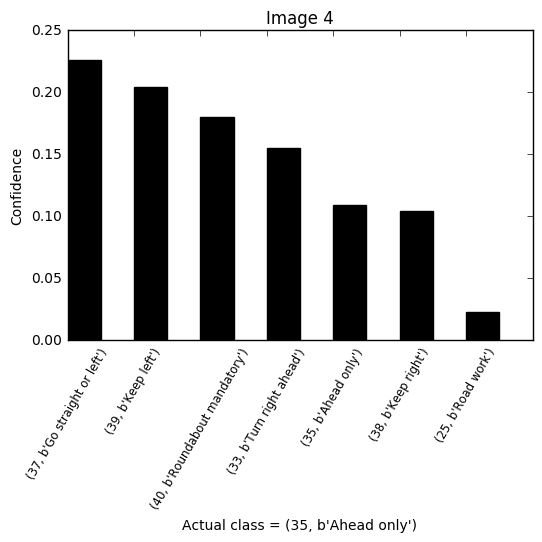

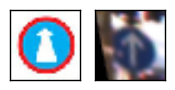

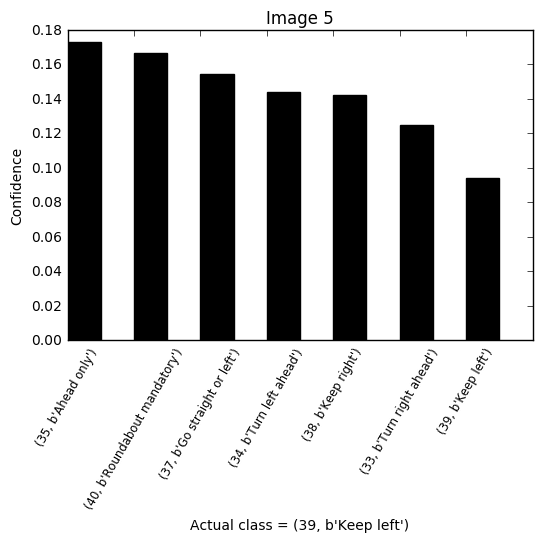

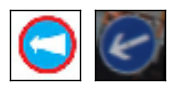

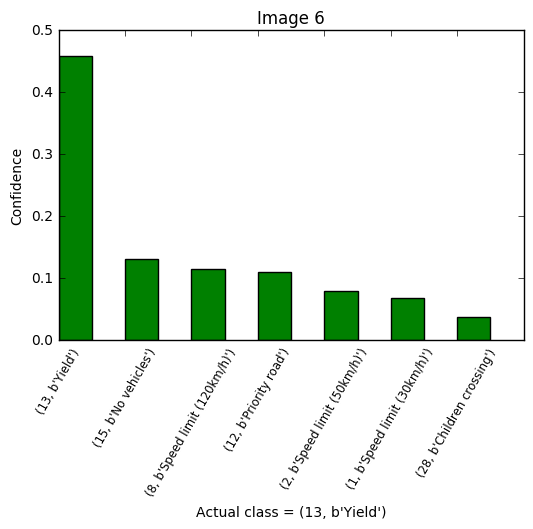

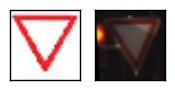

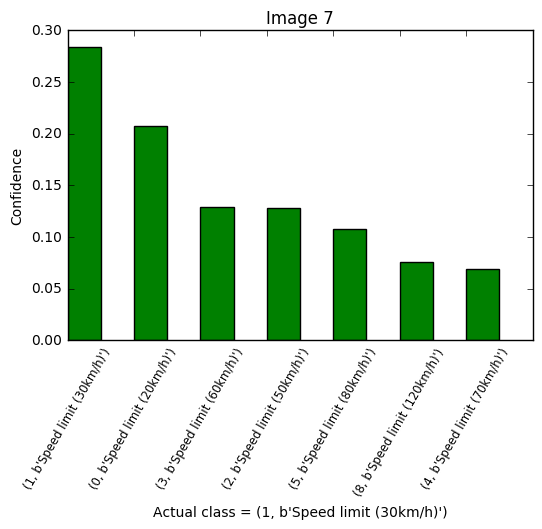

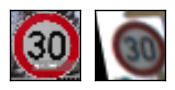

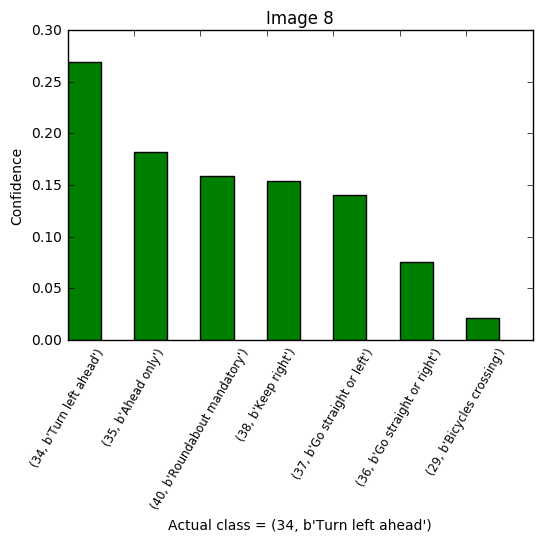

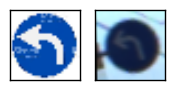

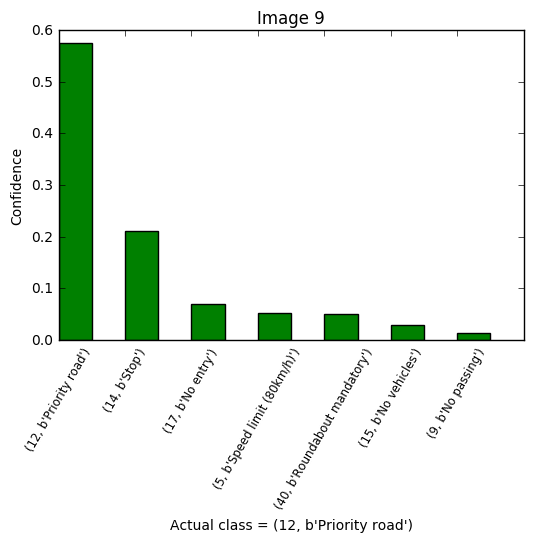

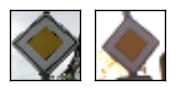

In [92]:
import heapq

y_axis = range(0,7,1)
for i in range(0, new_images_labels_predicted.shape[0],1):
    top7 = heapq.nlargest(7, range(len(new_images_labels_predicted[i])), new_images_labels_predicted[i].take)
    top7_vals = [new_images_labels_predicted[i][x] for x in top7]
    top7_labels = [str(class_labels[x]) for x in top7]
    norm2 = [x/np.sum(top7_vals) for x in top7_vals]
    color_val = "black"
    actual_class = new_images_labels_actual[i]
    if top7[0] == actual_class:
        color_val = "green"
    fig, ax = plt.subplots()
    rects = ax.bar(y_axis, norm2, width=0.5, color=color_val)
    ax.set_title("Image "+str(i))
    ax.set_xlabel("Actual class = "+str(class_labels[actual_class]))
    ax.set_ylabel("Confidence")
    ax.set_xticklabels(top7_labels, size="small", rotation=60)
    
    # Show original image
    fig = plt.figure(figsize = (2, 1))
    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(new_images[i])
    
    # Show resized image
    k = np.sum(counter2[:actual_class])+random.randint(1,counter2[actual_class]-1)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(X_train_final[k])
    

#     plt.bar(y_axis, norm2, top7_labels, ha='center', va='bottom')
#     print ("Top predictions = ", top7)
#     print ("Actual class = ", class_labels[actual_class])
    i+=1
    print ("--------------------")
    
        

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [27]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [28]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.